In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.models import load_model


from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.io import imread, imshow, imread_collection, concatenate_images

from keras import backend as K

seed = 42

In [3]:
#BEGIN LAB_1

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)


url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=url, untar=True)


In [4]:
data_dir

'/Users/ivanalchuk/.keras/datasets/flower_photos'

In [5]:
labels = ["roses", "sunflowers", "tulips", "dandelion", "daisy"]

In [6]:
%%time
pictures =[]

for l in labels:
    for path in os.listdir(os.path.join(data_dir, l)):
        full_path = os.path.join(data_dir, l, path)
        img = imread(full_path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)                   
        pictures.append(img) 

CPU times: user 46.9 s, sys: 1.32 s, total: 48.2 s
Wall time: 49.8 s


In [7]:
pictures = np.array(pictures)
pictures = pictures.astype('float32') / 255.

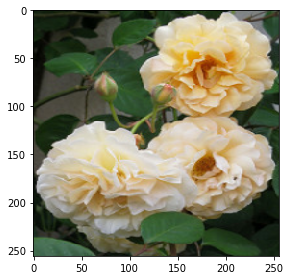

In [8]:
imshow(pictures[5])
plt.show()

In [9]:
pictures = pictures[:2000]
x_train, x_test = train_test_split(pictures, test_size = 10, random_state = seed)

In [10]:
pictures.shape

(2000, 256, 256, 3)

In [11]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)

In [12]:
inception.graph = tf.compat.v1.get_default_graph()


In [13]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 256, 256, 128)        1280      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 128)        0         ['conv2d_203[0][0]']          
 g2D)                                                                                             
                                                                                                  
 conv2d_204 (Conv2D)         (None, 128, 128, 128)        262272    ['max_pooling2d_4[0][0]'] 

In [14]:
%%time

datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
   
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

def image_a_b_gen(dataset, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch


CPU times: user 29 µs, sys: 1e+03 ns, total: 30 µs
Wall time: 30.8 µs


In [15]:
%%time
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)


model_callbacks = [learning_rate_reduction]

BATCH_SIZE = 20
history = model.fit(image_a_b_gen(x_train,BATCH_SIZE),
            epochs=15,
            verbose=1,
            steps_per_epoch=x_train.shape[0]/BATCH_SIZE,
             callbacks=model_callbacks)

1/1 [==============================] - 2s 2s/step
Epoch 1/15
99/99 [==============================] - 558s 6s/step - loss: 0.0464 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - 2s 2s/step2 - loss: 0.03


99/99 [==============================] - 585s 6s/step - loss: 0.0369 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - 3s 3s/step3 - loss: 0.03


99/99 [==============================] - 580s 6s/step - loss: 0.0370 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - 3s 3s/step6 - loss: 0.03


99/99 [==============================] - 588s 6s/step - loss: 0.0368 - lr: 0.0010
Epoch 5/15
99/99 [==============================] - 590s 6s/step - loss: 0.0370 - lr: 0.0010
Epoch 6/15
1/1 [==============================] - 2s 2s/step7 - loss: 0.04


99/99 [==============================] - 563s 6s/step - loss: 0.0369 - lr: 0.0010
Epoch 7/15
1/1 [==============================] - 3s 3s/step2 - loss: 0.03


100/99 [==============================] - ETA: -2s - loss: 0.0369
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 [==============================] - 570s 6s/step - loss: 0.0369 - lr: 0.0010
Epoch 8/15
1/1 [==============================] - 2s 2s/step4 - loss: 0.03


99/99 [==============================] - 569s 6s/step - loss: 0.0369 - lr: 5.0000e-04
Epoch 9/15
1/1 [==============================] - 2s 2s/step1 - loss: 0.03


99/99 [==============================] - 575s 6s/step - loss: 0.0369 - lr: 5.0000e-04
Epoch 10/15
100/99 [==============================] - ETA: -2s - loss: 0.0367
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
99/99 [==============================] - 576s 6s/step - loss: 0.0367 - lr: 5.0000e-04
Epoch 11/15
1/1 [==============================] - 3s 3s/step2 - loss: 0.03


99/99 [==============================] - 577s 6s/step - loss: 0.0364 - lr: 2.5000e-04
Epoch 12/15
1/1 [==============================] - 2s 2s/step6 - loss: 0.03


99/99 [==============================] - 574s 6s/step - loss: 0.0356 - lr: 2.5000e-04
Epoch 13/15
1/1 [==============================] - 2s 2s/step5 - loss: 0.03


99/99 [==============================] - 574s 6s/step - loss: 0.0353 - lr: 2.5000e-04
Epoch 14/15
1/1 [==============================] - 2s 2s/step5 - loss: 0.03


99/99 [==============================] - 573s 6s/step - loss: 0.0351 - lr: 2.5000e-04
Epoch 15/15
1/1 [==============================] - 2s 2s/step
CPU times: user 19h 36min 24s, sys: 1h 9min 48s, total: 20h 46min 13s
Wall time: 2h 23min 46s


Text(0.5, 1.0, 'LOSS')

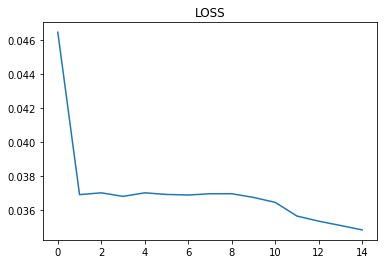

In [28]:
plt.plot(history.history['loss'])
plt.title('LOSS')

In [33]:
sample = x_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

1/1 [==============================] - 1s 915ms/step


/var/folders/np/lqn5pp917531z095xmy61_0m0000gn/T/ipykernel_2103/4014200414.py:16: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  decoded_imgs[i] = lab2rgb(cur)
/var/folders/np/lqn5pp917531z095xmy61_0m0000gn/T/ipykernel_2103/4014200414.py:17: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))
/var/folders/np/lqn5pp917531z095xmy61_0m0000gn/T/ipykernel_2103/4014200414.py:16: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40 negative Z values that have been clipped to zero
  decoded_imgs[i] = lab2rgb(cur)
/var/folders/np/lqn5pp917531z095xmy61_0m0000gn/T/ipykernel_2103/4014200414.py:17: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40 negative Z values that have been clipped to zero
  cv2.imwrite("img_"+str(i)+".jpg", la

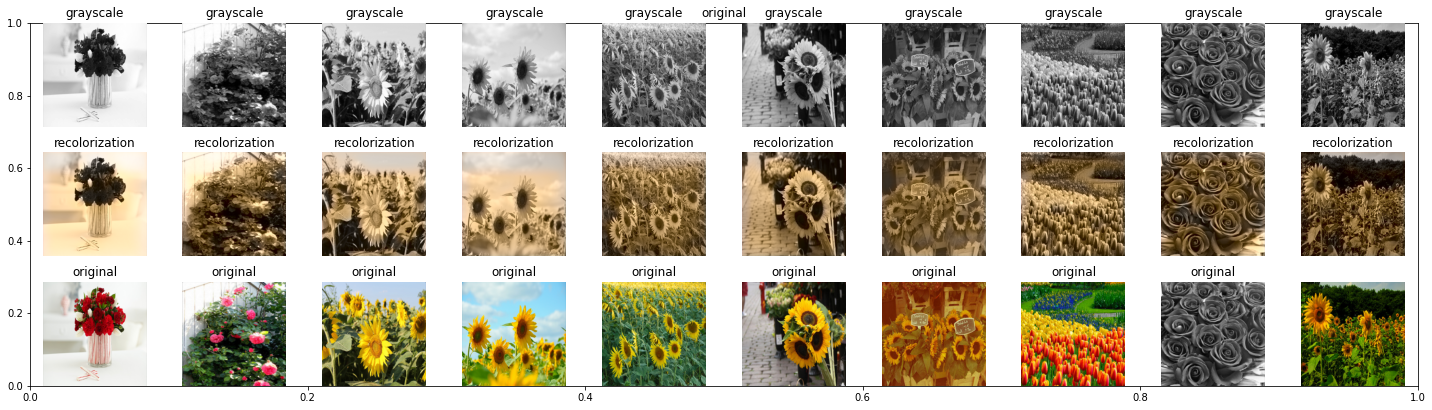

In [32]:
plt.figure(figsize=(20, 6))
for i in range(10):
    # grayscale
    plt.title('original')
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(x_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.title('grayscale')
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.title('recolorization')
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(x_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

In [21]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
pip install pydot

You should consider upgrading via the '/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
